Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pandas as pd
import shutil
import random
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
import time
from datetime import datetime
import datetime as dt
import copy
from efficientnet_pytorch import EfficientNet
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

In [2]:
from data_setup import copy_images_to_folders
from image_check import imshow
from model import CustomEfficientNetB0, validate_model, train_model, plot_metrics, visualize_model
from uncertainty_metrics import calculate_risks, process_labels, calculate_and_append_risks, calculate_and_append_risks_by_class, calculate_softmax_uncertainties, calculate_top2_softmax_uncertainties, calculate_random_uncertainties, calculate_mc_dropout_uncertainties_by_sample, calculate_mc_dropout_uncertainties_by_class, calculate_variance_uncertainties, calculate_variational_ratio_uncertainties, calculate_entropy_uncertainties, calculate_predictive_entropy_uncertainties, calculate_mutual_information_uncertainties, smooth_calcs, calculate_aurc, plot_risk_coverage

In [3]:
# use best algorithm for hardware
cudnn.benchmark = True

# interactive mode for graph plot
plt.ion()

# set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Sort data into folders based on class

In [4]:
csv_path = 'data/ISIC_2019_Training_GroundTruth.csv'
image_folder = 'data/ISIC_2019_Resized'
output_folder = 'data/ISIC_Sorted'

copy_images_to_folders(csv_path, image_folder, output_folder)

print("done")

done


Split data into training, validation and test

In [5]:
# declare variables for model creation
input_folder = 'data/ISIC_Sorted'  # This is the folder containing class subdirectories
output_folder = 'data/data_subset'  # The desired output folder for "training" and "validation" folders
sample_limit=None #None or a number up to 12875
train_ratio=0.6
val_ratio=0.2
test_ratio=0.2

if train_ratio+val_ratio+test_ratio != 1:
    print("invalid data ratios")

set_batch_size=64

#sample numbers by class copied here for reference
#MEL	NV	    BCC	    AK	 BKL	DF	VASC  SCC	UNK
#4522	12875	3323	867	 2624	239	253	  628	0

print("done")

done


In [6]:
training_folder = os.path.join(output_folder, 'train')
validation_folder = os.path.join(output_folder, 'val')
test_folder = os.path.join(output_folder, 'test')

In [7]:
# Remove existing "training" and "validation" folders if they exist
shutil.rmtree(training_folder, ignore_errors=True)
shutil.rmtree(validation_folder, ignore_errors=True)
shutil.rmtree(test_folder, ignore_errors=True)

# Create the "training" and "validation" folders
os.makedirs(training_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# generate list of class names from the folder structure
class_names = [class_name for class_name in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, class_name))]

print("done")

done


In [8]:
# Iterate through each class folder
for class_name in os.listdir(input_folder):
    class_folder_input = os.path.join(input_folder, class_name)
    if os.path.isdir(class_folder_input):
        # Get a list of all images in the class folder
        images = [img for img in os.listdir(class_folder_input) if img.endswith('.jpg')]
        
        # Limit the number of samples if sample_limit is provided
        if sample_limit is not None:
            images = images[:sample_limit]

        # Randomly shuffle the list of images
        np.random.seed(42)
        np.random.shuffle(images)

        # Calculate the number of samples for training and validation
        class_size = len(images)
        num_training_samples = int(class_size * train_ratio)
        num_val_samples = int(class_size * val_ratio)
        num_test_samples = int(class_size * test_ratio)

        # Create the class subfolders within the output folders
        class_folder_training = os.path.join(training_folder, class_name)
        class_folder_validation = os.path.join(validation_folder, class_name)
        class_folder_test = os.path.join(test_folder, class_name)
        os.makedirs(class_folder_training, exist_ok=True)
        os.makedirs(class_folder_validation, exist_ok=True)
        os.makedirs(class_folder_test, exist_ok=True)

        # Copy images to the training folder
        for image_name in images[:num_training_samples]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_training)
        # Copy images to the validation folder
        for image_name in images[num_training_samples:num_training_samples + num_val_samples]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_validation)
        # Copy images to the test folder
        for image_name in images[num_training_samples + num_val_samples:]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_test)

print("done")

done


In [9]:
#remove unknown folder as no samples
shutil.rmtree("data/data_subset/train/UNK", ignore_errors=True)
shutil.rmtree("data/data_subset/val/UNK", ignore_errors=True)
shutil.rmtree("data/data_subset/test/UNK", ignore_errors=True)

In [10]:
#transform data
data_transforms = {
'train': transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=360),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), shear=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'test': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
}

In [11]:
# create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(output_folder, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=set_batch_size, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

#print checks to see if the values are the same - if yes then can remove the assignment here
class_names = image_datasets['train'].classes
num_classes = len(class_names)
print(f"file: ", class_names)

file:  ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


show sample images

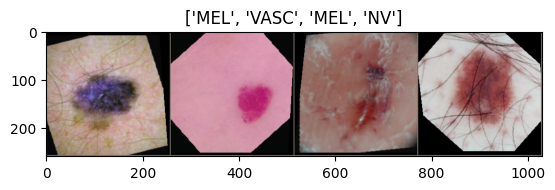

In [12]:
# Specify the number of images to display
num_images = 4

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Select a subset of images
inputs_subset = inputs[:num_images]
classes_subset = classes[:num_images]

# Make a grid from the subset
out = torchvision.utils.make_grid(inputs_subset)

imshow(out, title=[class_names[x] for x in classes_subset])

temporary fix for efficientnet weights issue

In [13]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model fitting configuration

In [14]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_epoch = 1

# Initialize the custom model with dropout
model_ft = CustomEfficientNetB0(num_classes=num_classes, dropout_prob=0.3)

# Move the model to the specified device (e.g., GPU or CPU)
model_ft = model_ft.to(device)

# Define the loss function (cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Use the Adam optimizer for training
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Define a learning rate scheduler to decay the learning rate
# by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b0


In [ ]:
#load the saved model
model_ft.load_state_dict(torch.load('data/trained_model.pth'))

In [15]:
train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, device, train_losses, train_accuracies, val_losses, val_accuracies, best_epoch, num_epochs=50, num_val_mc_samples=100, loss_weight=1, acc_weight=0, num_classes=num_classes)

Epoch 1/50 - 2024-03-10 03:29:36
----------
Train Loss: 0.1273, Train Acc: 0.6425
Val Loss: 0.1532, Val Acc: 0.6312

Epoch 2/50 - 2024-03-10 03:53:12
----------
Train Loss: 0.1082, Train Acc: 0.6915
Val Loss: 0.0990, Val Acc: 0.7112

Epoch 3/50 - 2024-03-10 04:13:47
----------
Train Loss: 0.0999, Train Acc: 0.7149
Val Loss: 0.0996, Val Acc: 0.7163

Epoch 4/50 - 2024-03-10 04:35:18
----------


KeyboardInterrupt: 

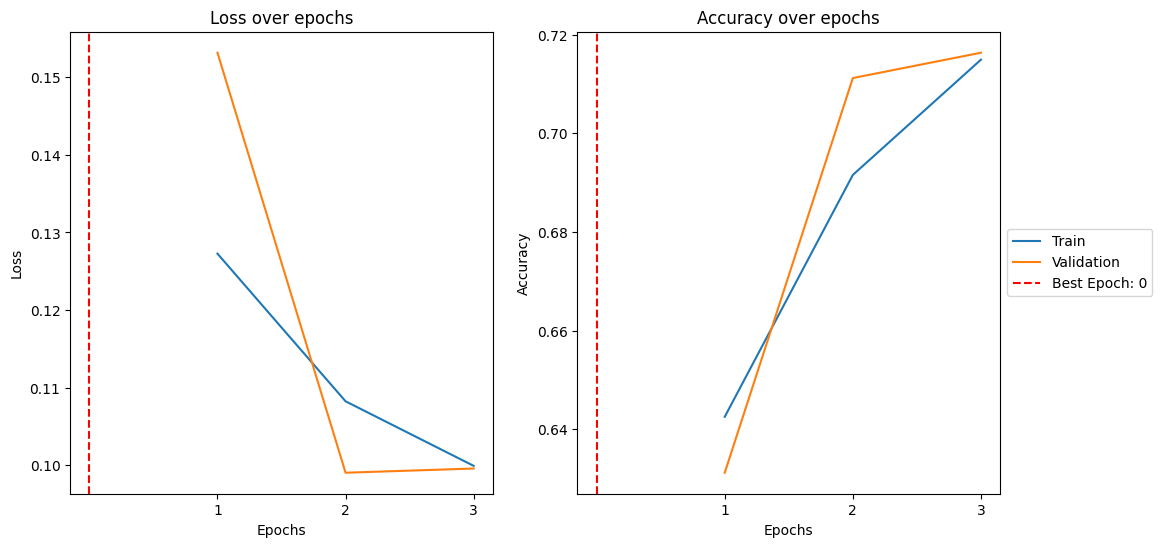

In [16]:
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, best_epoch)

In [ ]:
# Save the trained model
torch.save(model_ft.state_dict(), 'data/trained_model.pth')

visualise trained model

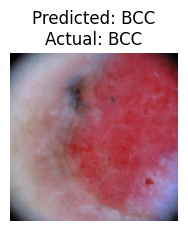

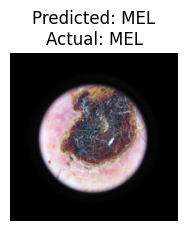

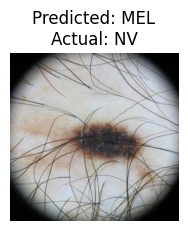

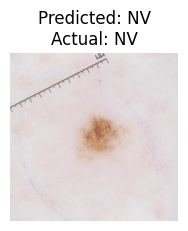

In [17]:
visualize_model(model_ft, dataloaders['val'], device, class_names, num_images=4)

In [18]:
def process_uncertainties(model, dataloader, class_names, device, uncertainty_function, uncertainty_name, *args, num_samples=None):
    # Calculate uncertainties using the provided function
    if num_samples is not None:
        guesses_are_correct, uncertainties, sample_labels = uncertainty_function(model, dataloader, class_names, device, num_samples)
    else:
        guesses_are_correct, uncertainties, sample_labels = uncertainty_function(model, dataloader, class_names, device)
    
    # Process labels and uncertainties by class
    guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
    
    # Append risks and labels to the global lists
    calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, uncertainty_name)
    calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, uncertainty_name)
    
    print(uncertainty_name, "processed")

# Lists to store results
risks_list = []
labels_list = []

risks_list_by_class = [[] for _ in range(len(class_names))]
labels_list_by_class = [[] for _ in range(len(class_names))]

uncertainty_functions = [
    (calculate_softmax_uncertainties, "Softmax Response"),
    (calculate_top2_softmax_uncertainties, "Top2 Softmax Difference"),
    (calculate_random_uncertainties, "Random Uncertainties"),
    (calculate_mc_dropout_uncertainties_by_sample, "MCD By Sample", 100),
    (calculate_mc_dropout_uncertainties_by_class, "MCD By Class", 100),
    (calculate_variance_uncertainties, "Variance"),
    (calculate_variational_ratio_uncertainties, "Variational Ratio"),
    (calculate_entropy_uncertainties, "Entropy"),
    (calculate_predictive_entropy_uncertainties, "Predictive Entropy", 100),
    (calculate_mutual_information_uncertainties, "Mutual Information")
]

# Iterate over each uncertainty calculation function
for function, name, *args in uncertainty_functions:
    # Call the process_uncertainties function with the current uncertainty calculation function and parameters
    process_uncertainties(model_ft, dataloaders['test'], class_names, device, function, name, *args)

print("Done")

Softmax Response processed
Top2 Softmax Difference processed
Random Uncertainties processed
2024-03-10 04:42:20.792837 - Batch 1/80 processed
2024-03-10 04:42:31.695842 - Batch 2/80 processed
2024-03-10 04:42:42.645395 - Batch 3/80 processed
2024-03-10 04:42:53.649888 - Batch 4/80 processed
2024-03-10 04:43:04.682510 - Batch 5/80 processed
2024-03-10 04:43:15.752816 - Batch 6/80 processed
2024-03-10 04:43:26.837774 - Batch 7/80 processed
2024-03-10 04:43:37.943368 - Batch 8/80 processed
2024-03-10 04:43:49.112719 - Batch 9/80 processed
2024-03-10 04:44:00.266617 - Batch 10/80 processed
2024-03-10 04:44:11.424842 - Batch 11/80 processed
2024-03-10 04:44:22.589458 - Batch 12/80 processed
2024-03-10 04:44:33.878545 - Batch 13/80 processed
2024-03-10 04:44:45.078100 - Batch 14/80 processed
2024-03-10 04:44:56.280306 - Batch 15/80 processed
2024-03-10 04:45:07.518229 - Batch 16/80 processed
2024-03-10 04:45:18.819502 - Batch 17/80 processed
2024-03-10 04:45:30.064770 - Batch 18/80 processed

In [19]:
description_list = [
    "Softmax Response measures the model's confidence in its predictions based on the softmax probabilities.",
    "Top2 Softmax Difference measures the uncertainty by calculating the difference between the top two softmax probabilities",
    "Random Uncertainties assigns random uncertainty values to each prediction, providing a baseline comparison for uncertainty estimation methods.",
    "MCD By Sample utilizes Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout.",
    "MCD By Class employs Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout for each class.",
    "Variance calculates uncertainty by computing the variance of softmax probabilities across classes for each prediction.",
    "Variational Ratio calculates uncertainty by computing the ratio of the maximum softmax probability (mode probability) to the maximum probability among other classes for each prediction.",
    "Entropy calculates uncertainty by measuring the entropy of softmax probabilities for each prediction.",
    "Predictive Entropy estimates uncertainty by averaging the entropy of softmax probabilities across multiple samples generated with dropout.",
    "Mutual Information computes uncertainty by measuring the mutual information between the model's softmax probabilities and a uniform distribution."
]

for description in description_list:
    print(f"- {description}")

print(
"""
- Risk = 1 - Accuracy, where Accuracy is the mean accuracy (normalised) over the samples included in the Coverage.
- Coverage is the normalised number of samples over the total samples. Coverage decreases as the most uncertain samples are removed.
- Area Under Risk Coverage (AURC) is the area under the Risk Coverage curve.

- Classes:
    - Melanoma (MEL)
    - Melanocytic nevus (NV)
    - Basal cell carcinoma (BCC)
    - Actinic keratosis (AK)
    - Benign keratosis (BKL) 
        [solar lentigo / seborrheic keratosis / lichen planus-like keratosis]
    - Dermatofibroma (DF)
    - Vascular lesion (VASC)
    - Squamous cell carcinoma (SCC)
    - None of the others (UNK)
"""
)

- Softmax Response measures the model's confidence in its predictions based on the softmax probabilities.
- Top2 Softmax Difference measures the uncertainty by calculating the difference between the top two softmax probabilities
- Random Uncertainties assigns random uncertainty values to each prediction, providing a baseline comparison for uncertainty estimation methods.
- MCD By Sample utilizes Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout.
- MCD By Class employs Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout for each class.
- Variance calculates uncertainty by computing the variance of softmax probabilities across classes for each prediction.
- Variational Ratio calculates uncertainty by computing the ratio of the maximum softmax probability (mode probability) to the maximum probability among other classes for each prediction.
- Entropy calculates unc

All Classes: 5074 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
MCD By Sample               	0.1025			0.1035
Variance                    	0.1026			0.1036
Softmax Response            	0.1026			0.1037
Top2 Softmax Difference     	0.1044			0.1054
Predictive Entropy          	0.1045			0.1055
Entropy                     	0.1051			0.1063
Variational Ratio           	0.1071			0.1084
MCD By Class                	0.1125			0.1161
Mutual Information          	0.1247			0.1300
Random Uncertainties        	0.2128			0.2663


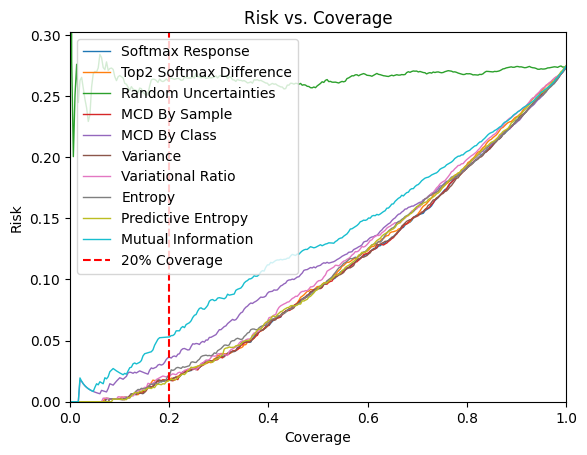

AK: 174 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Mutual Information          	0.5747			0.6760
MCD By Class                	0.6008			0.7282
Predictive Entropy          	0.6100			0.7648
Entropy                     	0.6134			0.7745
Variance                    	0.6298			0.7902
Random Uncertainties        	0.6301			0.8018
MCD By Sample               	0.6457			0.8194
Softmax Response            	0.6459			0.8203
Top2 Softmax Difference     	0.6627			0.8428
Variational Ratio           	0.6701			0.8575


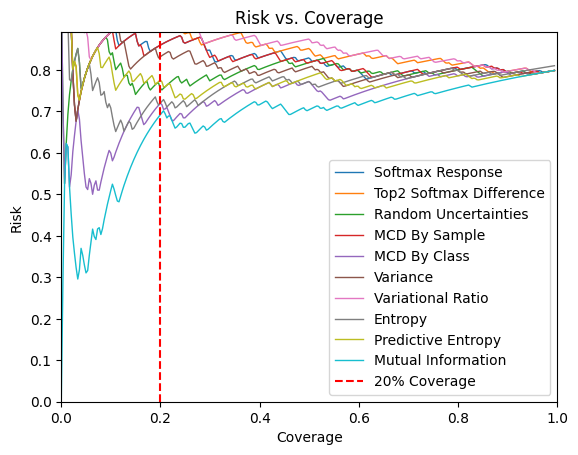


BCC: 666 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Top2 Softmax Difference     	0.1049			0.1267
Variational Ratio           	0.1050			0.1288
MCD By Sample               	0.1050			0.1297
Softmax Response            	0.1052			0.1301
Variance                    	0.1062			0.1312
MCD By Class                	0.1132			0.1396
Entropy                     	0.1146			0.1411
Predictive Entropy          	0.1154			0.1414
Mutual Information          	0.1369			0.1684
Random Uncertainties        	0.2010			0.2475


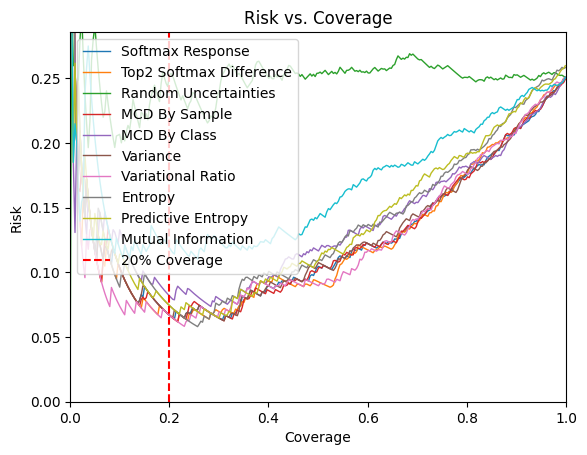


BKL: 526 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Mutual Information          	0.4993			0.6052
Random Uncertainties        	0.5210			0.6499
MCD By Class                	0.5320			0.6636
Entropy                     	0.5322			0.6751
Predictive Entropy          	0.5367			0.6766
Variance                    	0.5413			0.6811
Softmax Response            	0.5418			0.6812
MCD By Sample               	0.5419			0.6815
Top2 Softmax Difference     	0.5450			0.6839
Variational Ratio           	0.5452			0.6849


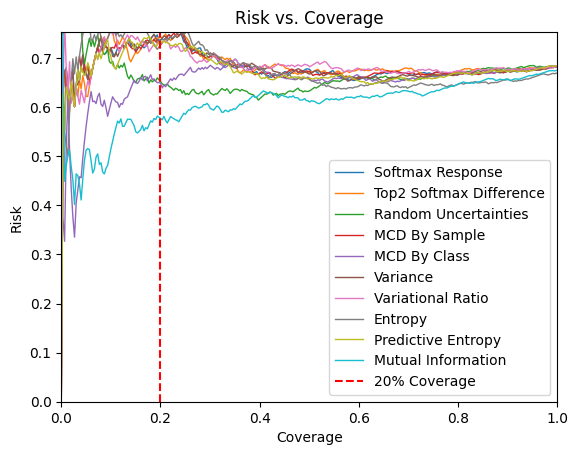


DF: 49 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Predictive Entropy          	0.4939			0.5870
MCD By Class                	0.4954			0.5925
Entropy                     	0.4969			0.5989
Mutual Information          	0.5055			0.5989
Softmax Response            	0.5058			0.6018
MCD By Sample               	0.5058			0.6071
Variance                    	0.5087			0.6120
Top2 Softmax Difference     	0.5198			0.6122
Variational Ratio           	0.5293			0.6228
Random Uncertainties        	0.5730			0.7445


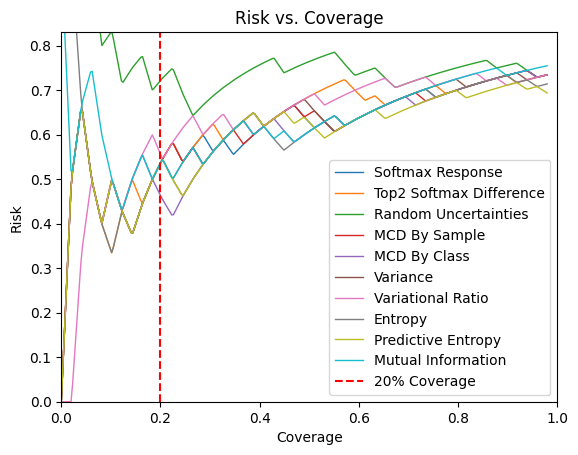


MEL: 905 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Variational Ratio           	0.2146			0.2173
Top2 Softmax Difference     	0.2198			0.2228
Softmax Response            	0.2254			0.2286
MCD By Sample               	0.2266			0.2300
Variance                    	0.2279			0.2310
Predictive Entropy          	0.2341			0.2378
Entropy                     	0.2350			0.2392
Mutual Information          	0.2529			0.2672
MCD By Class                	0.2619			0.2832
Random Uncertainties        	0.2958			0.3692


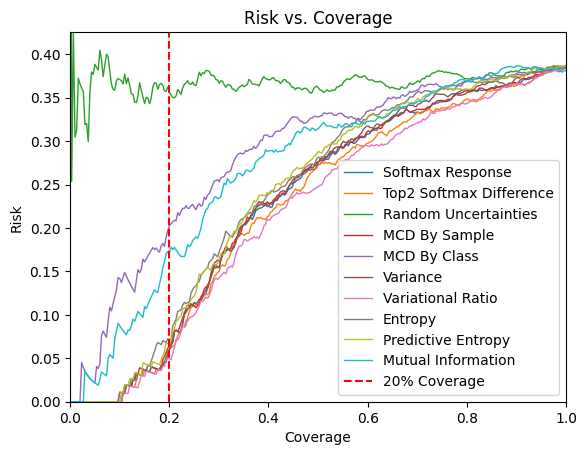


NV: 2575 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
MCD By Sample               	0.0142			0.0142
Softmax Response            	0.0143			0.0143
Variance                    	0.0146			0.0146
Top2 Softmax Difference     	0.0149			0.0149
Predictive Entropy          	0.0156			0.0156
Variational Ratio           	0.0158			0.0158
Entropy                     	0.0159			0.0159
MCD By Class                	0.0186			0.0186
Mutual Information          	0.0295			0.0299
Random Uncertainties        	0.0650			0.0769


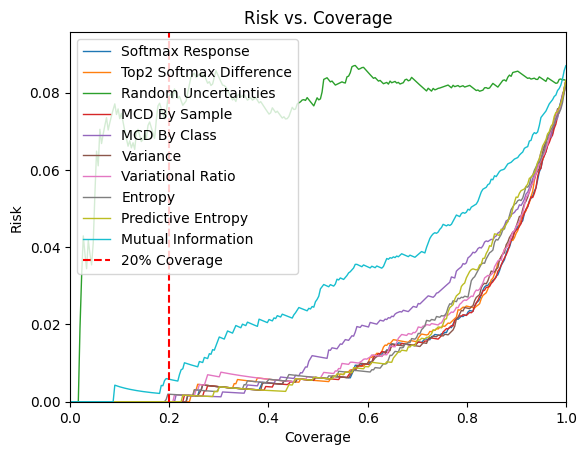


SCC: 127 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Random Uncertainties        	0.7039			0.8898
Mutual Information          	0.7281			0.9292
MCD By Class                	0.7524			0.9548
Entropy                     	0.7537			0.9561
Predictive Entropy          	0.7559			0.9583
Variance                    	0.7574			0.9598
MCD By Sample               	0.7581			0.9605
Softmax Response            	0.7582			0.9606
Variational Ratio           	0.7597			0.9621
Top2 Softmax Difference     	0.7598			0.9623


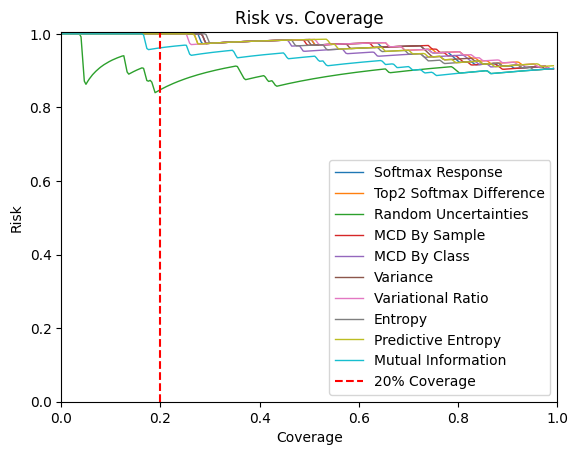


VASC: 52 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Variance                    	0.0267			0.0267
Top2 Softmax Difference     	0.0268			0.0268
Variational Ratio           	0.0269			0.0269
MCD By Sample               	0.0271			0.0271
Softmax Response            	0.0275			0.0275
Entropy                     	0.0295			0.0295
Predictive Entropy          	0.0301			0.0301
Mutual Information          	0.0311			0.0311
MCD By Class                	0.0330			0.0330
Random Uncertainties        	0.0807			0.0807


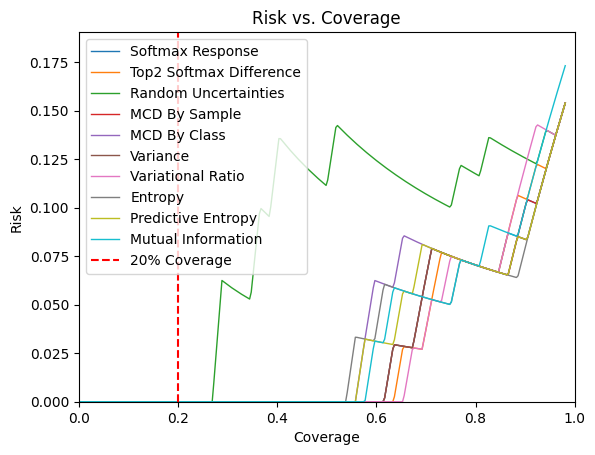


done


In [20]:
print(f"All Classes: {len(risks_list[0])} samples")
x_smooth_percentage_interp, x_smooth_percentage = smooth_calcs(risks_list[0])
calculate_aurc(risks_list, labels_list, x_smooth_percentage_interp, x_smooth_percentage)
# Plot the risk coverage curve
plot_risk_coverage(risks_list, labels_list, x_smooth_percentage_interp, x_smooth_percentage)

for i in range(len(class_names)):
    print(f"{class_names[i]}: {len(risks_list_by_class[i][0])} samples")
    x_smooth_percentage_interp, x_smooth_percentage = smooth_calcs(risks_list_by_class[i][0])
    calculate_aurc(risks_list_by_class[i], labels_list_by_class[i], x_smooth_percentage_interp, x_smooth_percentage)
    # Plot the risk coverage curve
    plot_risk_coverage(risks_list_by_class[i], labels_list_by_class[i], x_smooth_percentage_interp, x_smooth_percentage)
    print()
    
print("done")